In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score, precision_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2

%matplotlib inline

/home/csci8523/attan005/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
source_dir = os.path.join('train-jpg', 'train-jpg')

In [3]:
x_train = []
y_train = []

train_data = pd.read_csv('train_v2.csv/train_v2.csv')

label_enum = 0
label_map = {}
labels = {}
for tags in train_data['tags']:
    classes = tags.split(" ")
    for label in classes:
        if label not in label_map:
            label_map[label] = label_enum
            labels[label_enum] = label
            label_enum = label_enum + 1
    if label_enum == 17:
        break

for image, tags in train_data.values:
    image_path = source_dir+"/"+image+".jpg"
    img = cv2.imread(image_path)
    img = cv2.resize(img, (139, 139))
    one_hot_labels = np.zeros(len(label_map))
    for label in tags.split(' '):
        one_hot_labels[label_map[label]] = 1
    x_train.append(img/255.0)
    y_train.append(one_hot_labels)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

(40479, 139, 139, 3)
(40479, 17)


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.1)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size =0.5)
print(x_train.shape)
print(y_train.shape)

(36431, 139, 139, 3)
(36431, 17)


In [5]:
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (139, 139, 3))
pretrained_model.trainable = False

In [6]:
input_layer = pretrained_model.input
model_output = pretrained_model.output
pooling_layer = GlobalAveragePooling2D()(model_output)
dense_layer = Dense(2048, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(17, activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [7]:
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

Epoch 1/10
285/285 - 116s - loss: 0.1587 - accuracy: 0.8034 - val_loss: 0.1340 - val_accuracy: 0.8345 - 116s/epoch - 406ms/step
Epoch 2/10
285/285 - 92s - loss: 0.1298 - accuracy: 0.8164 - val_loss: 0.1307 - val_accuracy: 0.8132 - 92s/epoch - 323ms/step
Epoch 3/10
285/285 - 73s - loss: 0.1229 - accuracy: 0.8119 - val_loss: 0.1281 - val_accuracy: 0.7727 - 73s/epoch - 257ms/step
Epoch 4/10
285/285 - 78s - loss: 0.1171 - accuracy: 0.8085 - val_loss: 0.1276 - val_accuracy: 0.8310 - 78s/epoch - 274ms/step
Epoch 5/10
285/285 - 74s - loss: 0.1131 - accuracy: 0.7994 - val_loss: 0.1284 - val_accuracy: 0.8202 - 74s/epoch - 261ms/step
Epoch 6/10
285/285 - 80s - loss: 0.1087 - accuracy: 0.7942 - val_loss: 0.1290 - val_accuracy: 0.7930 - 80s/epoch - 281ms/step
Epoch 7/10
285/285 - 81s - loss: 0.1041 - accuracy: 0.7883 - val_loss: 0.1276 - val_accuracy: 0.7955 - 81s/epoch - 283ms/step
Epoch 8/10
285/285 - 88s - loss: 0.0996 - accuracy: 0.7791 - val_loss: 0.1297 - val_accuracy: 0.7717 - 88s/epoch - 3

In [8]:
model.save_weights('model_rgb_final.h5')

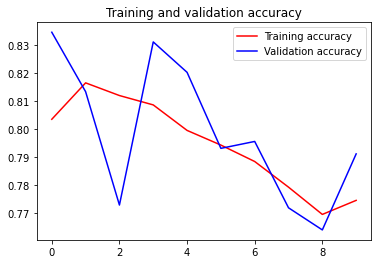

<Figure size 432x288 with 0 Axes>

In [9]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

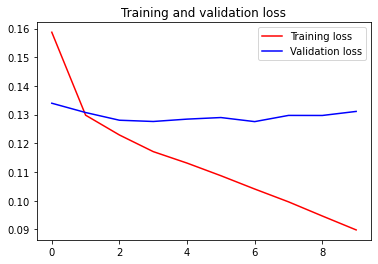

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
y_pred = model.predict(x_test, batch_size = 128, verbose=2)

16/16 - 5s - 5s/epoch - 326ms/step


In [12]:
f2_score = fbeta_score(y_test, np.array(y_pred)>0.2, beta=2, average='samples')
print("F2 score:",f2_score)

F2 score: 0.8868491131804358


In [13]:
y_pred = np.array(y_pred)>0.2
total = np.sum(y_test,axis = 0)
tp = np.sum(y_test*y_pred,axis=0)
tn = np.sum((1-y_test)*(1-y_pred),axis=0)
fp = np.sum((1-y_test)*y_pred,axis=0)
fn = np.sum(y_test*(1-y_pred),axis=0)

d = {'Total':total,'TP':tp,'TN':tn,'FP':fp,'FN':fn}
pd.DataFrame(d, index=label_map)


,Total,TP,TN,FP,FN
haze,144,110,1774,106,34
primary,1879,1873,67,78,6
agriculture,652,590,1066,306,62
clear,1442,1415,408,174,27
water,385,309,1400,239,76
habitation,216,150,1636,172,66
road,437,382,1400,187,55
cultivation,227,143,1525,272,84
slash_burn,6,0,2018,0,6
cloudy,101,88,1890,33,13


In [14]:
sum = np.add(tp, fp)
precision = np.divide(tp, sum)
recall = np.divide(tp, np.add(tp, fn))
accuracy = np.divide(np.add(tp, tn), np.add(fp, np.add(fn, np.add(tp, tn))))
f1 = 2*(np.divide(np.multiply(precision, recall), np.add(precision, recall)))
f2 = (np.divide(5*np.multiply(precision, recall), np.add(4*precision, recall)))
evalution_metrics = {'Accuracy':accuracy,'Precision':precision,'Recall':recall,'f1':f1, 'f2': f2}
pd.DataFrame(evalution_metrics, index=label_map)

<ipython-input-14-bd4fa39ebb4b>:2: RuntimeWarning: invalid value encountered in divide
  precision = np.divide(tp, sum)


,Accuracy,Precision,Recall,f1,f2
haze,0.930830,0.509259,0.763889,0.611111,0.694444
primary,0.958498,0.960021,0.996807,0.978068,0.989226
agriculture,0.818182,0.658482,0.904908,0.762274,0.841895
clear,0.900692,0.890497,0.981276,0.933685,0.961669
water,0.844368,0.563869,0.802597,0.662379,0.739943
habitation,0.882411,0.465839,0.694444,0.557621,0.632378
road,0.880435,0.671353,0.874142,0.759443,0.824342
cultivation,0.824111,0.344578,0.629956,0.445483,0.540438
slash_burn,0.997036,NaN,0.000000,NaN,NaN
cloudy,0.977273,0.727273,0.871287,0.792793,0.838095


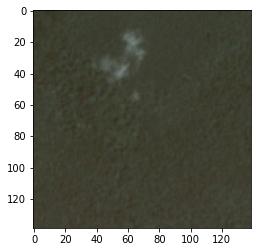

1/1 - 0s - 30ms/epoch - 30ms/step
[False  True False  True False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary clear partly_cloudy 


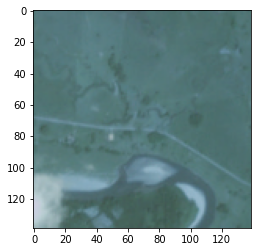

1/1 - 0s - 62ms/epoch - 62ms/step
[False  True  True  True  True  True  True False False False False False
 False False False False False]
True label
primary agriculture water road partly_cloudy 
Predicted
primary agriculture clear water habitation road 


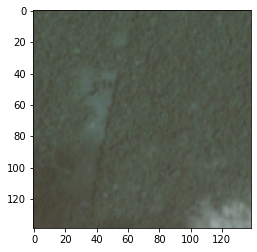

1/1 - 0s - 43ms/epoch - 43ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary agriculture cultivation partly_cloudy 
Predicted
primary partly_cloudy 


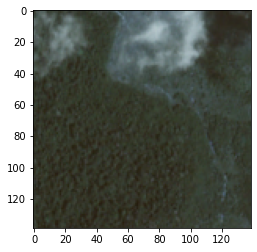

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True False  True False  True False False False  True False
 False False False False False]
True label
primary agriculture road partly_cloudy 
Predicted
primary agriculture water road partly_cloudy 


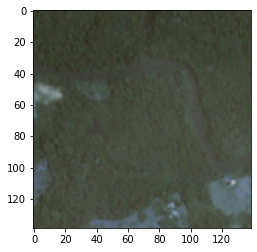

1/1 - 0s - 32ms/epoch - 32ms/step
[False  True  True  True False  True False  True False False False False
 False False False False False]
True label
primary agriculture water habitation cultivation partly_cloudy 
Predicted
primary agriculture clear habitation cultivation 


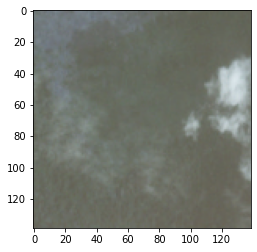

1/1 - 0s - 29ms/epoch - 29ms/step
[False  True False False  True False False False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary water partly_cloudy 


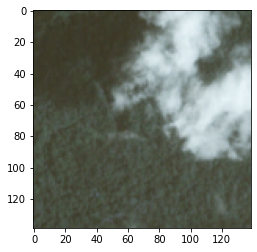

1/1 - 0s - 29ms/epoch - 29ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


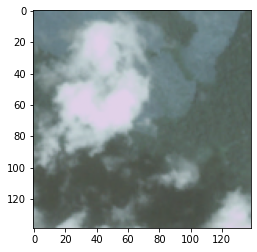

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True False  True False False False False False  True False
 False False False False False]
True label
primary agriculture cultivation partly_cloudy 
Predicted
primary agriculture water partly_cloudy 


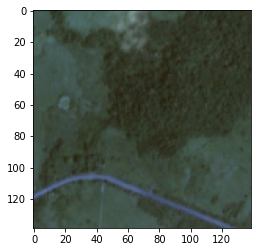

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True  True  True False  True False False False False False
 False False False False False]
True label
primary agriculture road partly_cloudy 
Predicted
primary agriculture clear water road 


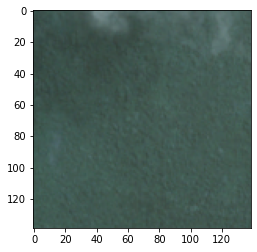

1/1 - 0s - 30ms/epoch - 30ms/step
[False  True  True  True False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture clear partly_cloudy 


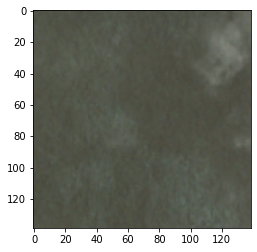

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True  True False False False  True False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture clear cultivation partly_cloudy 


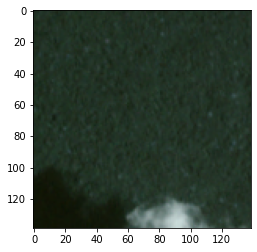

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


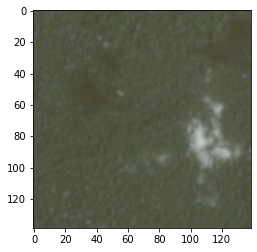

1/1 - 0s - 32ms/epoch - 32ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


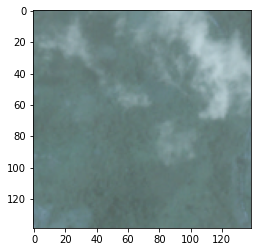

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary road partly_cloudy 
Predicted
primary agriculture partly_cloudy 


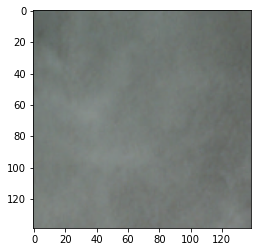

1/1 - 0s - 31ms/epoch - 31ms/step
[ True  True False False False False False False False  True False False
 False False False False False]
True label
primary partly_cloudy 
Predicted
haze primary cloudy 


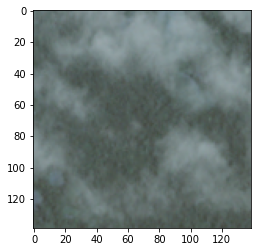

1/1 - 0s - 32ms/epoch - 32ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary cultivation partly_cloudy 
Predicted
primary partly_cloudy 


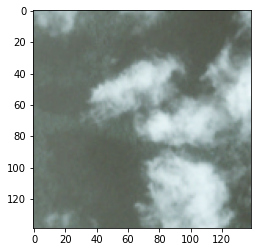

1/1 - 0s - 32ms/epoch - 32ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


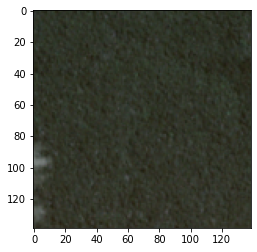

1/1 - 0s - 32ms/epoch - 32ms/step
[False  True False  True False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary clear partly_cloudy 


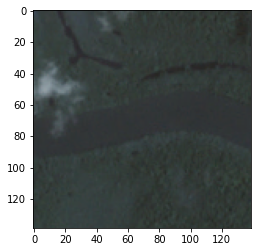

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True  True  True False  True False False False  True False
 False False False False False]
True label
primary water partly_cloudy 
Predicted
primary agriculture clear water road partly_cloudy 


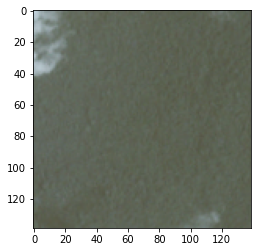

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True False  True False False False  True False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary clear cultivation partly_cloudy 


In [15]:
j = 0
k=0
while(j<20 and k<len(x_test)):
    img = x_test[k]
    tags = ''
    y = y_test[k]
    cloudy = False
    for i in range(len(y)):
        if y[i] == 1:
            tags = tags + labels[i] + ' '
            if labels[i] == 'partly_cloudy':
                cloudy = True
    if cloudy:
        plt.imshow(img)
        plt.show()
        img = np.expand_dims(img, axis = 0)
        y = model.predict(img, batch_size = 1, verbose=2)
        y_pred = np.array(y > 0.2).reshape(-1)
        print(y_pred)
        preds = ""
        for i in range(len(y_pred)):
            if y_pred[i] != 0:
                preds = preds+labels[i]+" "
        print('True label')
        print(tags)
        print('Predicted')
        print(preds)
        j+=1
    k=k+1

##### 